In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from glob import glob
import librosa
get_ipython().magic('matplotlib inline')

In [3]:
import librosa as lr
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [4]:
#Loading the required RAVDESS DataSet with length of 1440 Audio Files 
os.listdir('/content/drive/MyDrive/Colab Notebooks/speech-emotion-recognition-ravdess-data')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = '/content/drive/MyDrive/Colab Notebooks/speech-emotion-recognition-ravdess-data'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1440

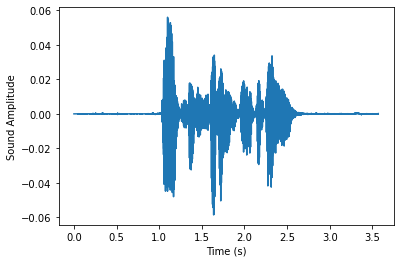

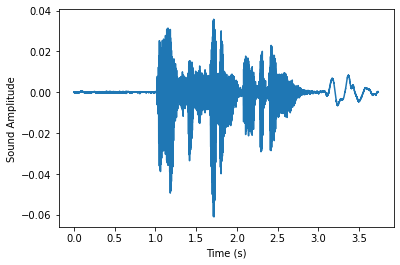

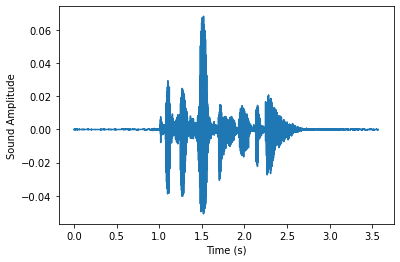

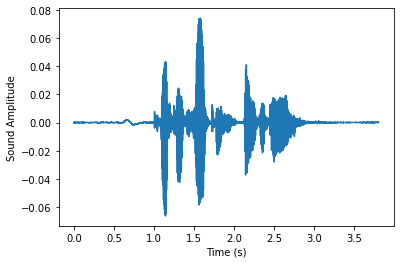

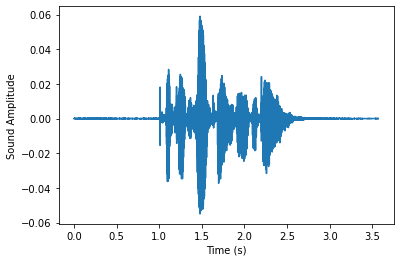

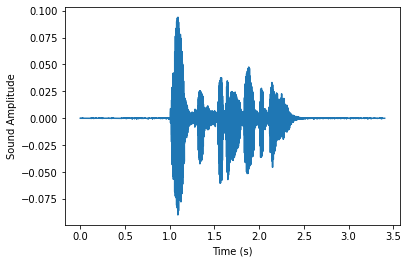

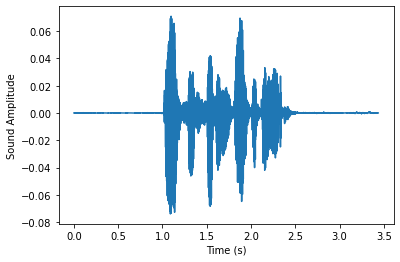

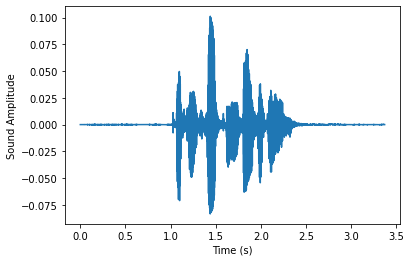

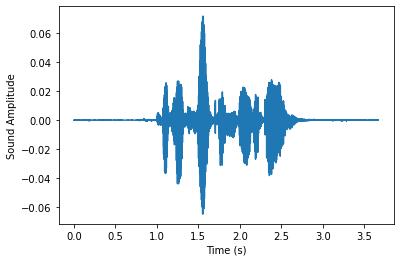

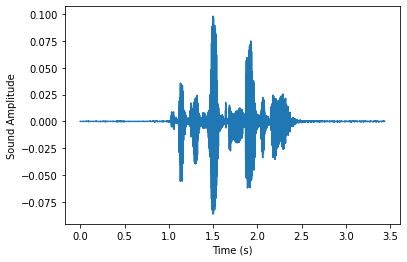

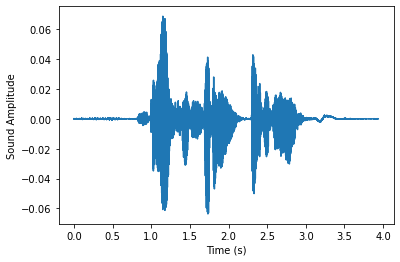

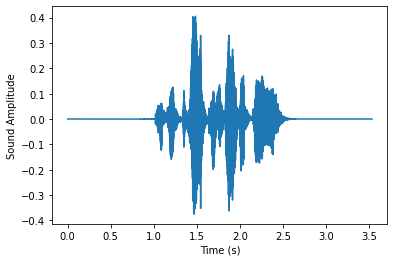

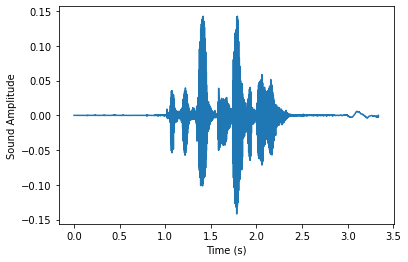

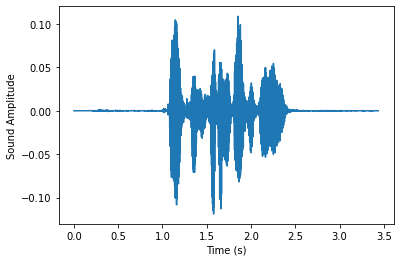

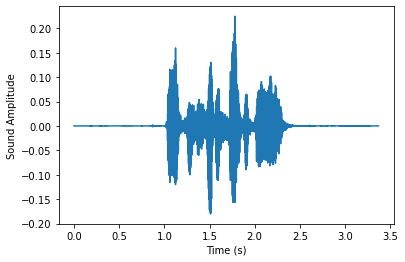

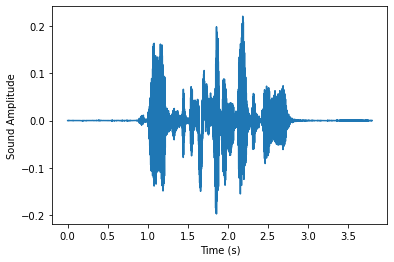

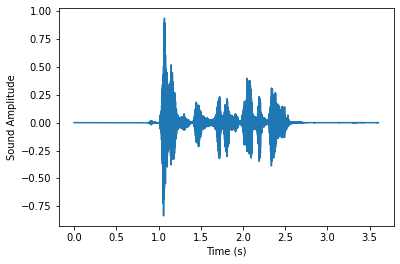

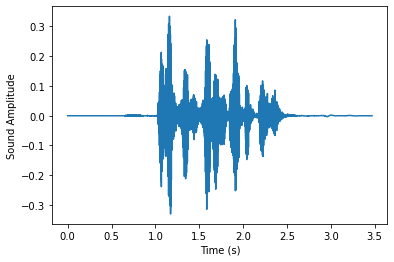

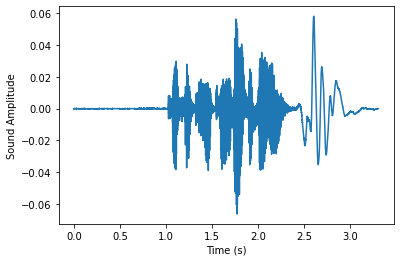

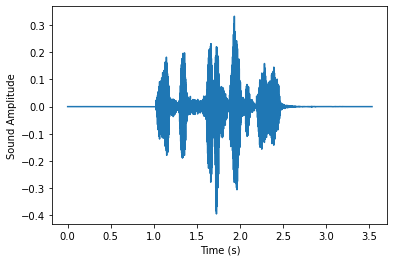

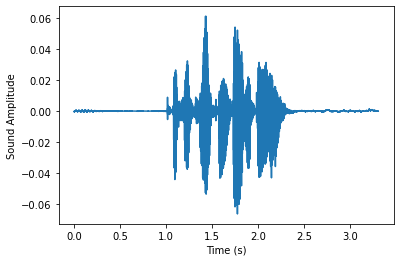

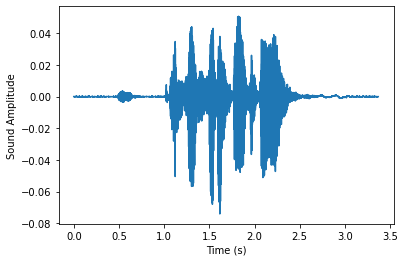

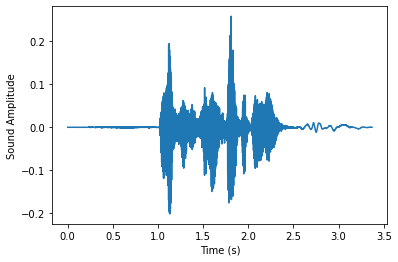

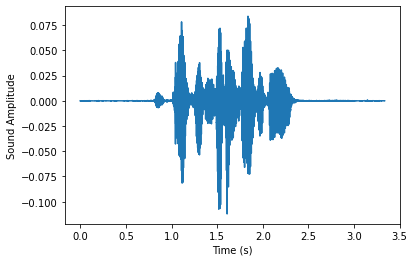

KeyboardInterrupt: ignored

In [5]:
#Plotting the Basic Graphs for understanding of Audio Files :
for file in range(0 , len(listOfFiles) , 1):
    audio , sfreq = lr.load(listOfFiles[file])
    time = np.arange(0 , len(audio)) / sfreq
    
    fig ,ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
    plt.show()

In [6]:
#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.
#They are the Plotting Functions to be called later. 
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

In [7]:
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

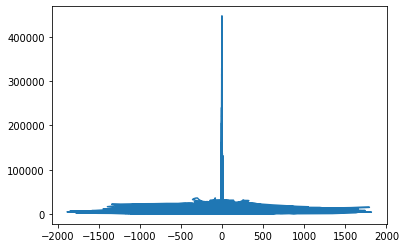

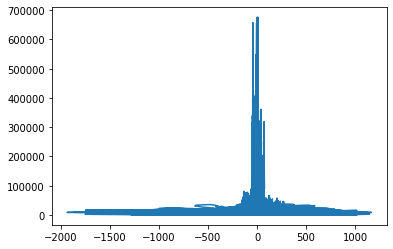

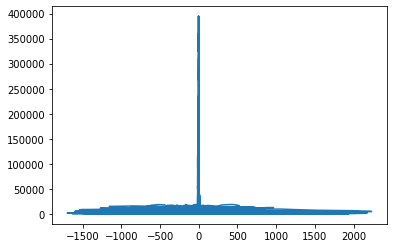

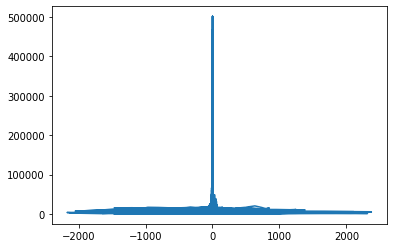

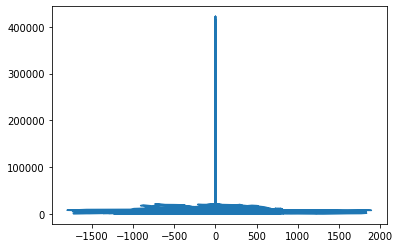

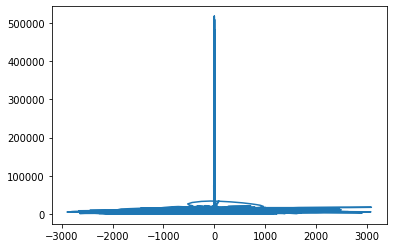

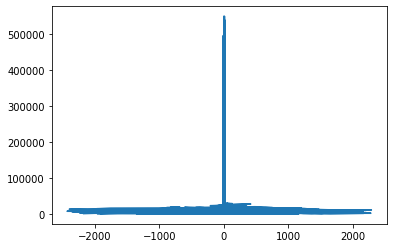

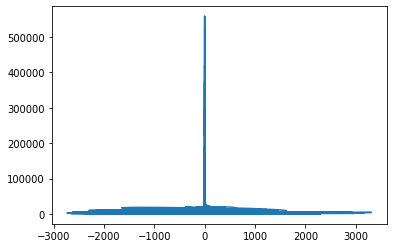

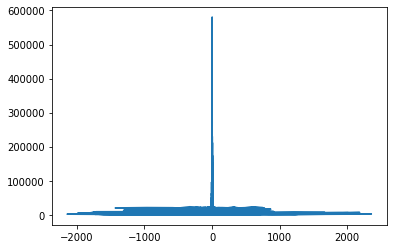

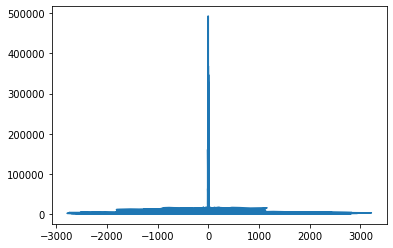

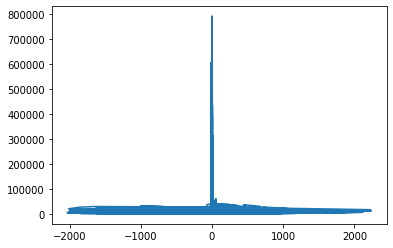

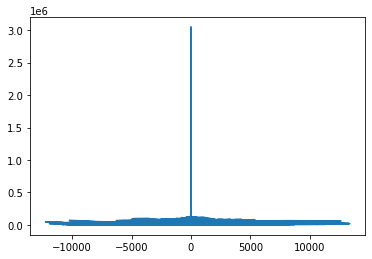

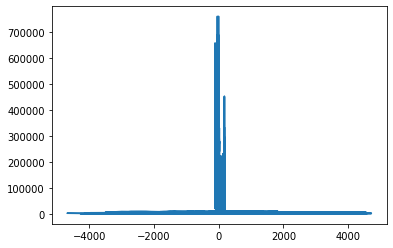

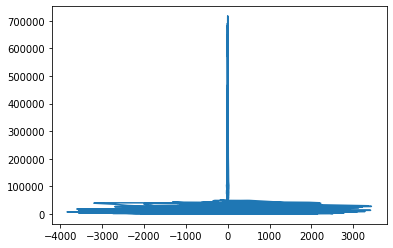

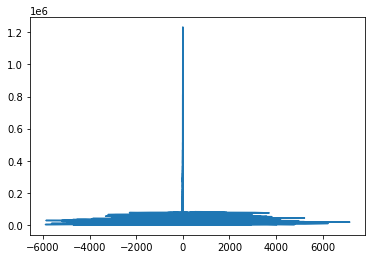

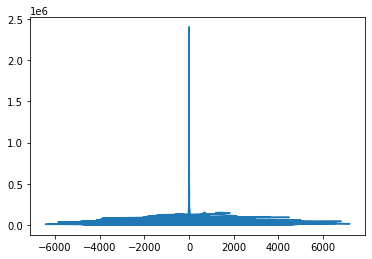

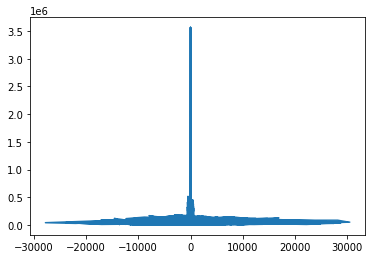

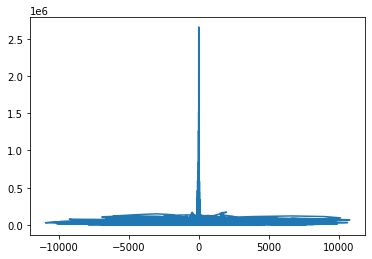

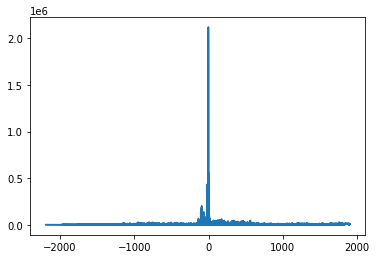

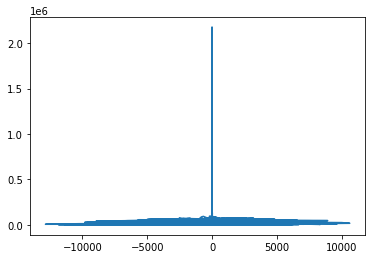

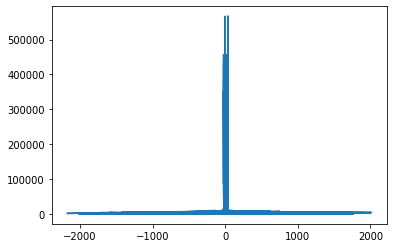

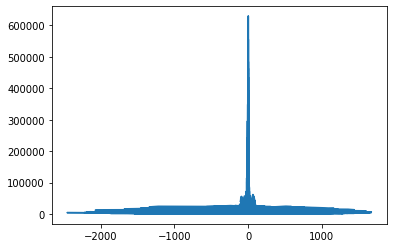

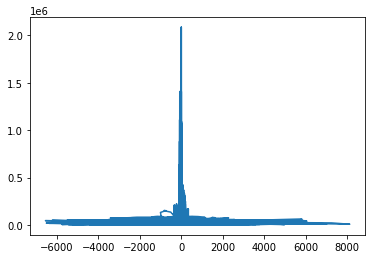

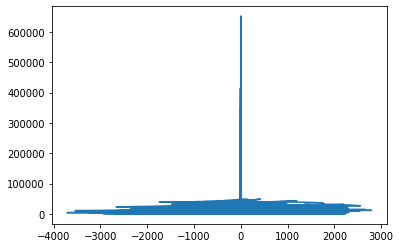

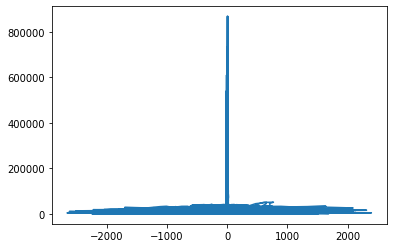

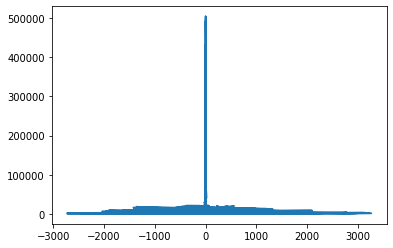

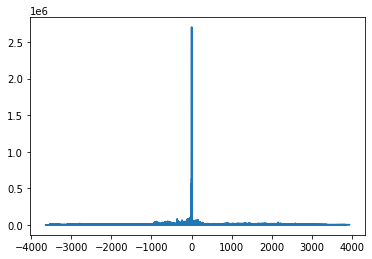

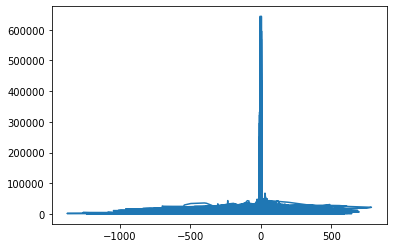

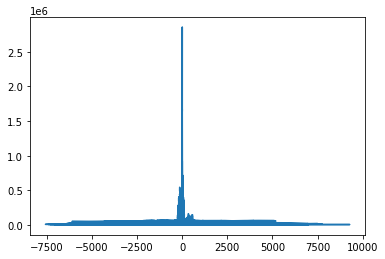

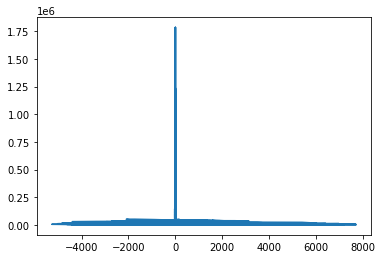

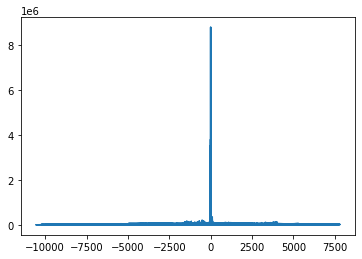

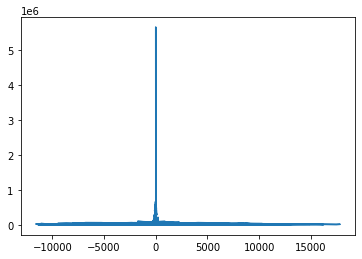

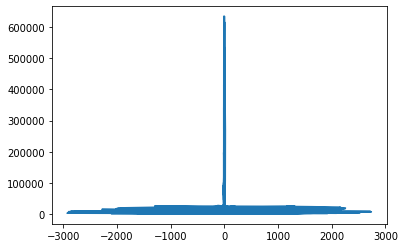

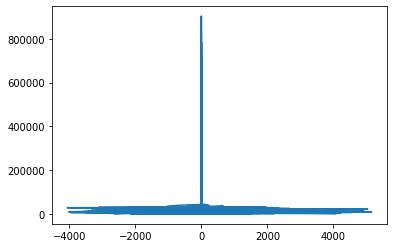

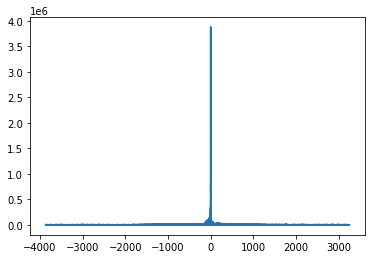

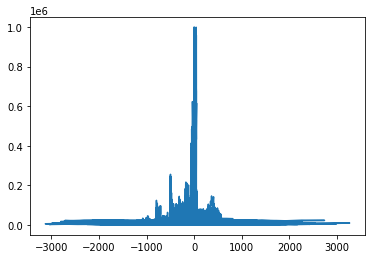

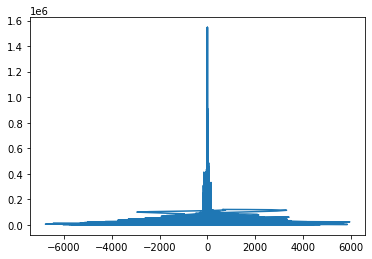

KeyboardInterrupt: ignored

In [8]:
# Here The Data Set is loaded and plots are Visualised by Calling the Plotting Functions . 
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
for file in range(0 , len(listOfFiles) , 1):
    rate, data = wav.read(listOfFiles[file])
    fft_out = fft(data)
    %matplotlib inline
    plt.plot(data, np.abs(fft_out))
    plt.show()
    
signals={}
fft={}
fbank={}
mfccs={}
# load data
for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wavfile.read(listOfFiles[file])
     signal,rate =librosa.load(listOfFiles[file] , sr=44100)
     mask = envelope(signal , rate , 0.0005)
     signals[file] = signal
     fft[file] = calc_fft(signal , rate)
    
     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
     fbank[file] = bank
     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
     mfccs[file]=mel
    
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [9]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [10]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
observed_emotions=['neutral','calm','happy','sad','angry','fearful', 'disgust','surprised']

In [11]:
def load_data(test_size=0.25):
    x,y=[],[]
    for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/speech-emotion-recognition-ravdess-data/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, train_size= 0.75, random_state=100)

In [12]:
# Split the dataset
import time
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [13]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [14]:
# Initialize the Multi Layer Perceptron Classifier
model = MLPClassifier(alpha = 0.01, batch_size = 32, hidden_layer_sizes = (64,32,32,16,8), learning_rate = 'adaptive', max_iter = 215)

In [15]:
#Train the model
model.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (215) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.01, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(64, 32, 32, 16, 8), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=215,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [16]:
#Predict for the test set
y_pred=model.predict(x_test)

In [17]:
#SAVING THE MODEL
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [18]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(activation='relu', alpha=0.01, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(64, 32, 32, 16, 8), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=215,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [19]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['neutral', 'calm', 'happy', 'calm', 'disgust', 'sad', 'happy',
       'disgust', 'surprised', 'sad', 'happy', 'fearful', 'calm', 'happy',
       'sad', 'happy', 'calm', 'surprised', 'happy', 'angry', 'sad',
       'sad', 'happy', 'happy', 'disgust', 'disgust', 'fearful',
       'surprised', 'sad', 'surprised', 'happy', 'surprised', 'calm',
       'disgust', 'calm', 'calm', 'fearful', 'sad', 'calm', 'calm',
       'calm', 'calm', 'sad', 'fearful', 'surprised', 'calm', 'happy',
       'disgust', 'happy', 'calm', 'calm', 'calm', 'sad', 'fearful',
       'calm', 'calm', 'happy', 'neutral', 'surprised', 'disgust',
       'surprised', 'angry', 'calm', 'angry', 'fearful', 'angry',
       'surprised', 'happy', 'happy', 'calm', 'calm', 'calm', 'angry',
       'disgust', 'fearful', 'sad', 'calm', 'neutral', 'calm', 'neutral',
       'happy', 'disgust', 'surprised', 'angry', 'happy', 'calm', 'angry',
       'calm', 'calm', 'calm', 'fearful', 'angry', 'sad', 'calm',
       'surprised', 'fea

In [20]:
#Calculate the accuracy of our model
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 50.00%


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.69      0.49      0.57        45
        calm       0.51      0.76      0.61        51
     disgust       0.50      0.53      0.51        51
     fearful       0.53      0.36      0.43        56
       happy       0.48      0.43      0.45        51
     neutral       0.13      0.12      0.13        24
         sad       0.45      0.50      0.47        34
   surprised       0.57      0.62      0.59        48

    accuracy                           0.50       360
   macro avg       0.48      0.48      0.47       360
weighted avg       0.51      0.50      0.49       360



In [22]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,y_pred)
print (matrix)

[[22  2  2  7  3  3  1  5]
 [ 0 39  3  2  0  4  3  0]
 [ 0  2 27  0  7  1  4 10]
 [ 6  5  6 20 12  0  3  4]
 [ 3  3  4  6 22  4  6  3]
 [ 0 13  5  0  0  3  3  0]
 [ 0  8  2  3  0  3 17  1]
 [ 1  4  5  0  2  5  1 30]]
